<a href="https://colab.research.google.com/github/apof/ChAI---Deep-Kernel-Learning-combining-GPs-with-DL/blob/main/Neural_Net_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy

In [ ]:
batch_size= 256

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/SNLP/')
import utils
import models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/h_aluminium_vectors')
aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/h_aluminium_labels')
aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/h_aluminium_dates')

copper_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/h_copper_vectors')
copper_labels = joblib.load('drive/MyDrive/Thesis_Vectors/h_copper_labels')
copper_dates = joblib.load('drive/MyDrive/Thesis_Vectors/h_copper_dates')

'''aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_vectors')
aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_labels')
aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_dates')

copper_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/copper_vectors')
copper_labels = joblib.load('drive/MyDrive/Thesis_Vectors/copper_labels')
copper_dates = joblib.load('drive/MyDrive/Thesis_Vectors/copper_dates')'''

dates = copper_dates

In [ ]:
print(aluminium_inputs.shape)
print(aluminium_labels.shape)
print(aluminium_dates.shape)

print(copper_inputs.shape)
print(copper_labels.shape)
print(copper_dates.shape)

(3718, 100, 28)
(3718,)
(3718,)
(3718, 100, 18)
(3718,)
(3718,)


In [ ]:
def align_timeseries(aluminium_inputs,aluminium_labels,aluminium_dates,copper_inputs,copper_labels,copper_dates):
  
  al_in = []
  al_lbl = []
  d = []
  c_in = []
  c_lbl = []

  al_dict = {}

  for i,inp in enumerate(aluminium_inputs):
    al_dict[aluminium_dates[i]] = (inp,aluminium_labels[i])

  for i,inp in enumerate(copper_inputs):
    if(al_dict.get(copper_dates[i]) != None):
      al_in.append(al_dict.get(copper_dates[i])[0])
      al_lbl.append(al_dict.get(copper_dates[i])[1])
      c_in.append(inp)
      c_lbl.append(copper_labels[i])
      d.append(copper_dates[i])

  return np.array(al_in),np.array(al_lbl),np.array(c_in),np.array(c_lbl),d



In [ ]:
#aluminium_inputs,aluminium_labels,copper_inputs,copper_labels,dates =  align_timeseries(aluminium_inputs,aluminium_labels,aluminium_dates,copper_inputs,copper_labels,copper_dates)

In [ ]:
print(aluminium_inputs.shape)
print(aluminium_labels.shape)

print(copper_inputs.shape)
print(copper_labels.shape)

print(len(dates))

(3718, 100, 28)
(3718,)
(3718, 100, 18)
(3718,)
3718


In [ ]:
al_train_batches,al_validation_batches,al_test_batches = utils.train_test_split(aluminium_inputs,aluminium_labels,dates,aluminium_inputs.shape[0],0.8,0.5,0)

In [ ]:
c_train_batches,c_validation_batches,c_test_batches = utils.train_test_split(copper_inputs,copper_labels,dates,copper_inputs.shape[0],0.8,0.5,0)

In [ ]:
al_train_data,al_train_labels,al_train_dates = al_train_batches[0]
al_test_data,al_test_labels,al_test_dates = al_test_batches[0]
al_val_data,al_val_labels,al_val_dates = al_validation_batches[0]
#print("Train Dates: " + al_train_dates[0] + " " + al_train_dates[-1])
#print("Val Dates: " + al_val_dates[0] + " " + al_val_dates[-1])
#print("Test Dates: " + al_test_dates[0] + " " + al_test_dates[-1])

In [ ]:
n = int(len(al_train_data)/batch_size)
index = n*batch_size
al_train_data = al_train_data[0:index]
al_train_labels = al_train_labels[0:index]
al_train_dates = al_train_dates[0:index]
al_test_data = al_test_data[0:batch_size]
al_test_labels = al_test_labels[0:batch_size]
al_test_dates = al_test_dates[0:batch_size]
al_val_data = al_val_data[0:batch_size]
al_val_labels = al_val_labels[0:batch_size]
al_val_dates = al_val_dates[0:batch_size]

In [ ]:
c_train_data,c_train_labels,c_train_dates = c_train_batches[0]
c_test_data,c_test_labels,c_test_dates = c_test_batches[0]
c_val_data,c_val_labels,c_val_dates = c_validation_batches[0]
#print("Train Dates: " + c_train_dates[0] + " " + c_train_dates[-1])
#print("Val Dates: " + c_val_dates[0] + " " + c_val_dates[-1])
#print("Test Dates: " + c_test_dates[0] + " " + c_test_dates[-1])

n = int(len(al_train_data)/batch_size)
index = n*batch_size
c_train_data = c_train_data[0:index]
c_train_labels = c_train_labels[0:index]
c_train_dates = c_train_dates[0:index]
c_test_data = c_test_data[0:batch_size]
c_test_labels = c_test_labels[0:batch_size]
c_test_dates = c_test_dates[0:batch_size]
c_val_data = c_val_data[0:batch_size]
c_val_labels = c_val_labels[0:batch_size]
c_val_dates = c_val_dates[0:batch_size]

In [ ]:
al_train_data = torch.from_numpy(al_train_data).to(dtype=torch.float16).to(device)
al_train_labels = torch.from_numpy(al_train_labels).to(dtype=torch.float16).to(device)
al_test_data = torch.from_numpy(al_test_data).to(dtype=torch.float16).to(device)
al_test_labels = torch.from_numpy(al_test_labels).to(dtype=torch.float16).to(device)
al_val_data = torch.from_numpy(al_val_data).to(dtype=torch.float16).to(device)
al_val_labels = torch.from_numpy(al_val_labels).to(dtype=torch.float16).to(device)

In [ ]:
c_train_data = torch.from_numpy(c_train_data).to(dtype=torch.float16).to(device)
c_train_labels = torch.from_numpy(c_train_labels).to(dtype=torch.float16).to(device)
c_test_data = torch.from_numpy(c_test_data).to(dtype=torch.float16).to(device)
c_test_labels = torch.from_numpy(c_test_labels).to(dtype=torch.float16).to(device)
c_val_data = torch.from_numpy(c_val_data).to(dtype=torch.float16).to(device)
c_val_labels = torch.from_numpy(c_val_labels).to(dtype=torch.float16).to(device)

In [ ]:
al_train_labels = torch.reshape(al_train_labels, (al_train_labels.shape[0], 1))
al_test_labels = torch.reshape(al_test_labels, (al_test_labels.shape[0], 1))
al_val_labels = torch.reshape(al_val_labels, (al_val_labels.shape[0], 1))

In [ ]:
c_train_labels = torch.reshape(c_train_labels, (c_train_labels.shape[0], 1))
c_test_labels = torch.reshape(c_test_labels, (c_test_labels.shape[0], 1))
c_val_labels = torch.reshape(c_val_labels, (c_val_labels.shape[0], 1))

In [ ]:
print(al_train_data.shape)
print(al_train_labels.shape)
print(al_test_data.shape)
print(al_test_labels.shape)
print(al_val_data.shape)
print(al_val_labels.shape)

torch.Size([2816, 100, 28])
torch.Size([2816, 1])
torch.Size([256, 100, 28])
torch.Size([256, 1])
torch.Size([256, 100, 28])
torch.Size([256, 1])


In [ ]:
print(c_train_data.shape)
print(c_train_labels.shape)
print(c_test_data.shape)
print(c_test_labels.shape)
print(c_val_data.shape)
print(c_val_labels.shape)

torch.Size([2816, 100, 18])
torch.Size([2816, 1])
torch.Size([256, 100, 18])
torch.Size([256, 1])
torch.Size([256, 100, 18])
torch.Size([256, 1])


In [ ]:
joint_train_labels = torch.cat((al_train_labels, c_train_labels), 1)
joint_valid_labels = torch.cat((al_val_labels, c_val_labels), 1)
joint_test_labels = torch.cat((al_test_labels, c_test_labels), 1)

In [ ]:
print(joint_train_labels.shape)
print(joint_valid_labels.shape)
print(joint_test_labels.shape)

torch.Size([2816, 2])
torch.Size([256, 2])
torch.Size([256, 2])


In [ ]:
train_set = torch.utils.data.TensorDataset(al_train_data, c_train_data, joint_train_labels)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [ ]:
## define a dictionary with the parameters of the Neural Network
params_dictionary = {}
params_dictionary['embedding_size'] = (al_train_data[0].shape[1],c_train_data[0].shape[1])
params_dictionary['hidden_dim'] = 512
params_dictionary['linear_dims'] = [128,64]
params_dictionary['bidirectional'] = True
params_dictionary['label_size'] = 2
params_dictionary['dropout'] = 0.3
params_dictionary['rnn_layers_num'] = 1
params_dictionary['concat_layer'] = [32]
params_dictionary['timesteps'] = al_train_data[0].shape[0]
params_dictionary['attention_layer'] = True
params_dictionary['kernel_size'] = 5
params_dictionary['cnn_reduced_dim_1'] = 25
params_dictionary['cnn_reduced_dim_2'] = 14
params_dictionary['cnn_layer'] = False

In [ ]:
model = models.MultiTaskModel(device,params_dictionary)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
loss = nn.MSELoss()
#loss = nn.L1Loss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
train_loss = []
valid_loss = []

training_iter = 10000
    
#for early stopping :
best_cost=1000000 
stop = False
last_improvement=0
require_improvement = 50
best_model = None
epoch = 0

reg_rate = 0.0001
regularisation = None
#regularisation = 'l2'
#regularisation = 'l1'

while epoch < training_iter and stop == False:
  epoch += 1
  loss_batches = []
  stateful_flag = True
  hidden1 = None
  hidden2 = None

  for batch_index,training_batch in enumerate (train_set_loader,0):

    al_input_batch,c_input_batch,joint_labels = training_batch
    optimizer.zero_grad()

    y_pred,hidden1,hidden2 = model.forward((al_input_batch,c_input_batch,stateful_flag,hidden1,hidden2))

    if(regularisation == None):
      single_loss = loss(y_pred,joint_labels.float()).to(device)
    else:
      single_loss = loss(y_pred,joint_labels.float()).to(device) + model.multitask_reg(reg_rate,regularisation)

    single_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_batches.append(single_loss.item())
    stateful_flag = False
  train_loss.append(np.mean(np.array(loss_batches[-1])))

  ## compute and store the validation loss
  valid_pred,_,_ = model.forward((al_val_data,c_val_data,stateful_flag,hidden1,hidden2))
  val_loss = loss(valid_pred,joint_valid_labels.float().to(device)).item()
  valid_loss.append(val_loss)

  print("epoch  " + str(epoch) + " " + str(train_loss[-1]))
  print("epoch  " + str(epoch) + " " + str(valid_loss[-1]))
  clear_output(wait=True)

  avg_cost = val_loss
  if avg_cost < best_cost:
    best_cost = avg_cost
    last_improvement = 0
    best_model_state = copy.deepcopy(model.state_dict())
    torch.save(best_model_state, 'drive/MyDrive/Thesis_Models/multitask_model.pt')
  else:
    last_improvement +=1
            
  if last_improvement > require_improvement:
    print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
    # Break out from the loop.
    stop = True
            

No improvement found during the last iterations, stopping optimization at epoch: 405


In [ ]:
model = models.MultiTaskModel(device,params_dictionary)
model.load_state_dict(torch.load('drive/MyDrive/Thesis_Models/multitask_model.pt'))
model.eval()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


MultiTaskModel(
  (net1): RnnRegressor(
    (attention): Attention(
      (concat_linear): Linear(in_features=2048, out_features=1024, bias=True)
      (attn): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (conv1d_layer1): Conv1d(28, 25, kernel_size=(5,), stride=(1,))
    (conv1d_layer2): Conv1d(25, 14, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool_2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation_func_1): LeakyReLU(negative_slope=0.1)
    (activation_func_2): LeakyReLU(negative_slope=0.1)
    (rnn): LSTM(28, 512, batch_first=True, dropout=0.3, bidirectional=True)
    (linears): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Linear(in_features=1024, out_features=128, bias=True)
      (2): Tanh()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): Tanh()
    )
  

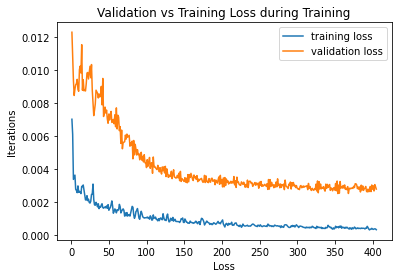

In [ ]:
iters = [i+1 for i in range(len(train_loss))]
plt.plot(iters, train_loss ,label = "training loss")
plt.plot(iters, valid_loss, label = "validation loss")
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Validation vs Training Loss during Training')
plt.legend()
plt.show()

In [ ]:
validation_predictions,_,_ = model.forward((al_val_data,c_val_data,None,hidden1,hidden2))
test_predictions,_,_ = model.forward((al_test_data,c_test_data,None,hidden1,hidden2))
joint_test_labels = joint_test_labels
joint_valid_labels = joint_valid_labels
joint_train_labels = joint_train_labels

In [ ]:
train_predictions = []
for batch_index,training_batch in enumerate (train_set_loader,0):
    al_input_batch,c_input_batch,joint_labels = training_batch
    predictions,_,_ = model.forward((al_input_batch,c_input_batch,None,hidden1,hidden2))
    train_predictions.append(predictions.cpu().detach().numpy())

In [ ]:
train_predictions = np.array(train_predictions)
print(train_predictions.shape)
train_predictions = np.reshape(train_predictions, (train_predictions.shape[0]*train_predictions.shape[1],train_predictions.shape[2]))
print(train_predictions.shape)

(11, 256, 2)
(2816, 2)


In [ ]:
print(loss(validation_predictions,joint_valid_labels))

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
index_1 = [i+1 for i in range(len(validation_predictions))]
index_2 = [i+1 for i in range(len(test_predictions))]
index_3 = [i+1 for i in range(len(train_predictions))]

In [ ]:
validation_predictions = validation_predictions.cpu().detach().numpy()
joint_valid_labels = joint_valid_labels.cpu().detach().numpy()
test_predictions = test_predictions.cpu().detach().numpy()
joint_test_labels = joint_test_labels.cpu().detach().numpy()
joint_train_labels = joint_train_labels.cpu().detach().numpy()

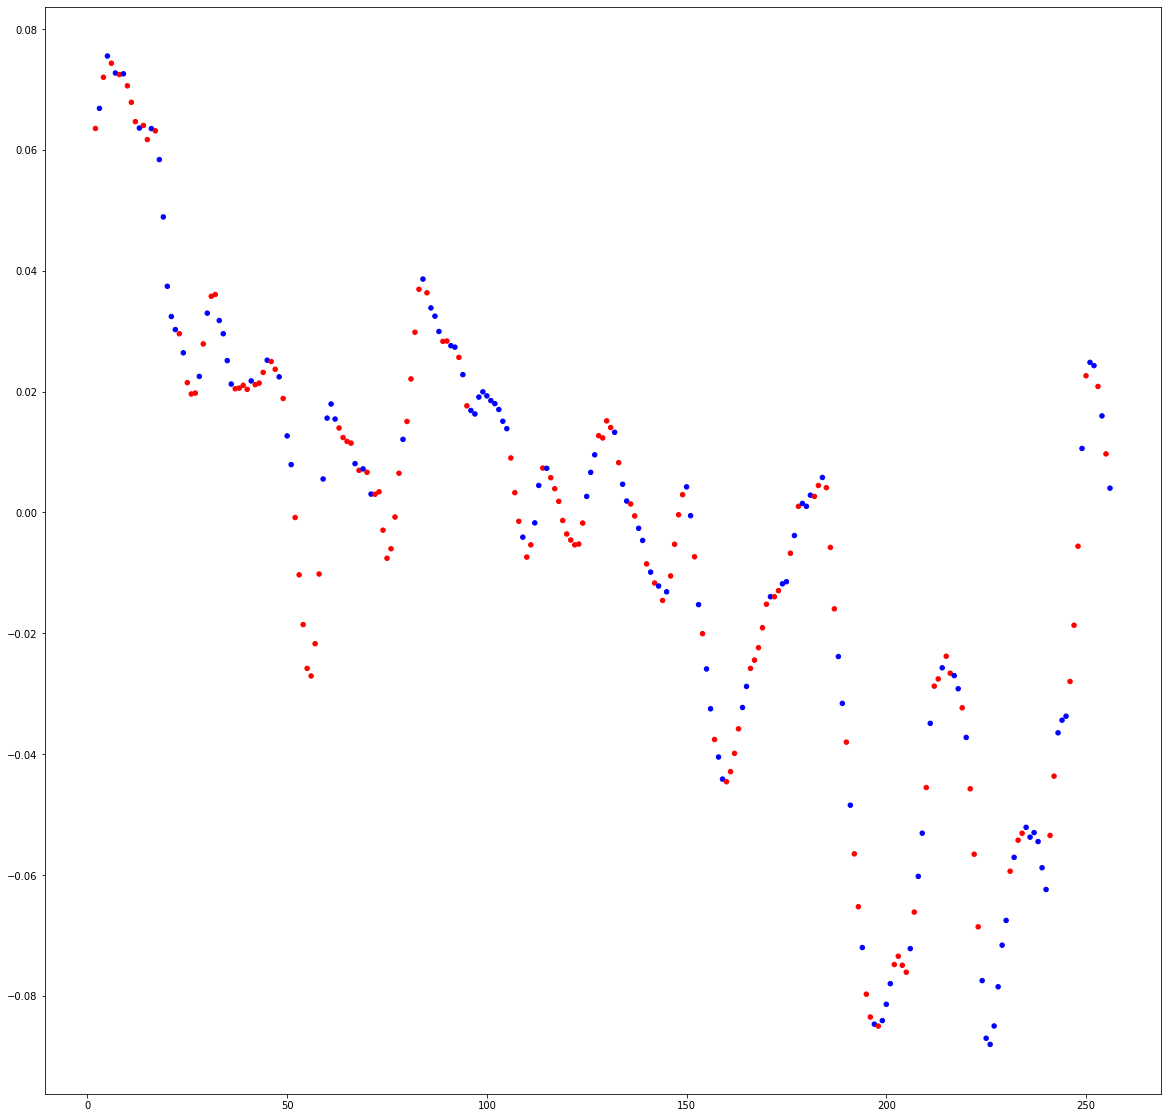

In [ ]:
utils.plot_directional_results(validation_predictions[:,0],joint_valid_labels[:,0],index_1)

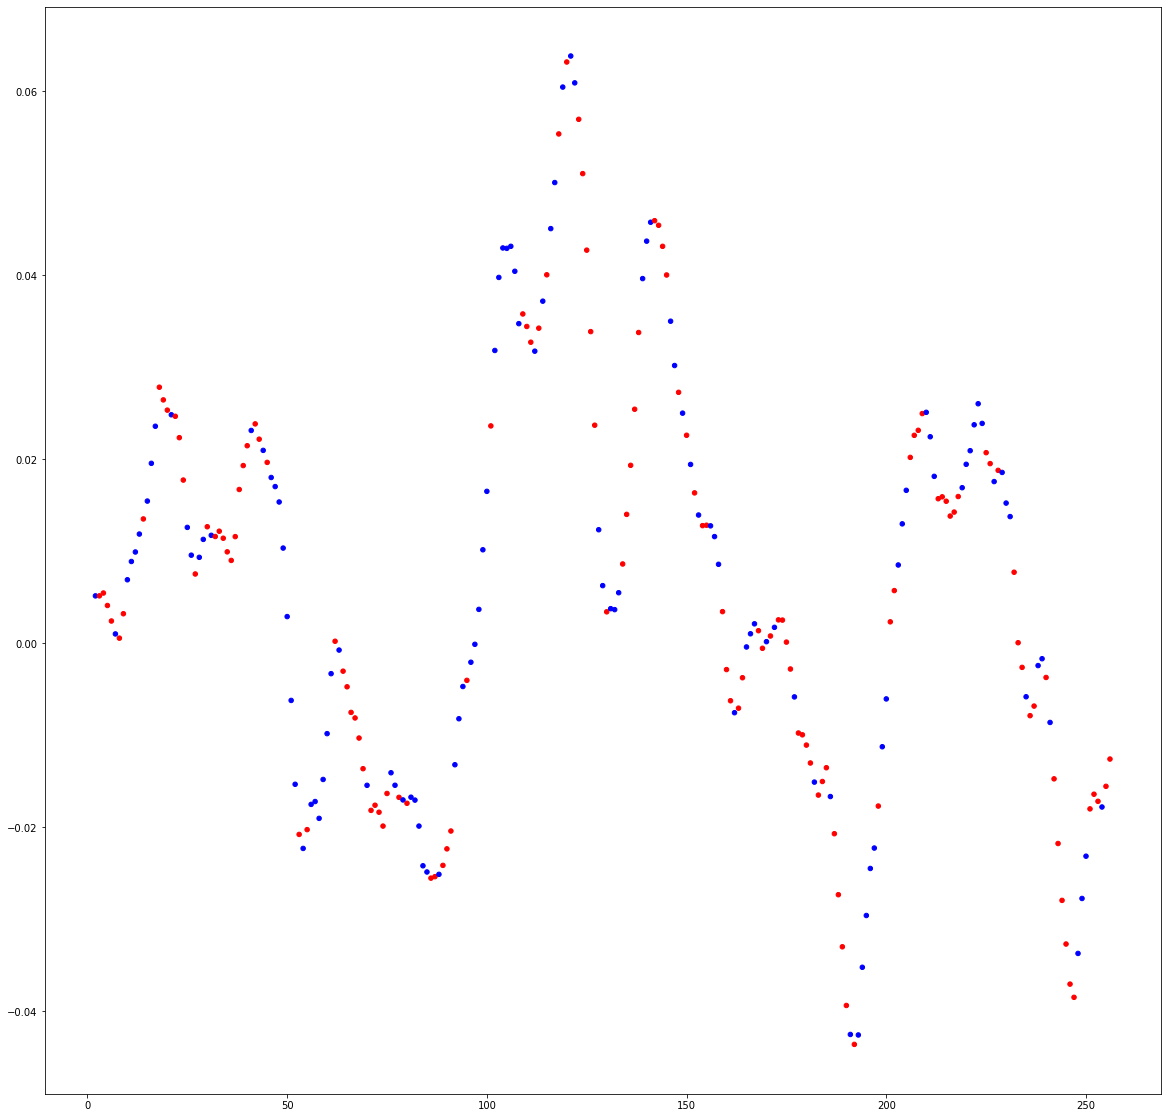

In [ ]:
utils.plot_directional_results(test_predictions[:,0],joint_test_labels[:,0],index_2)

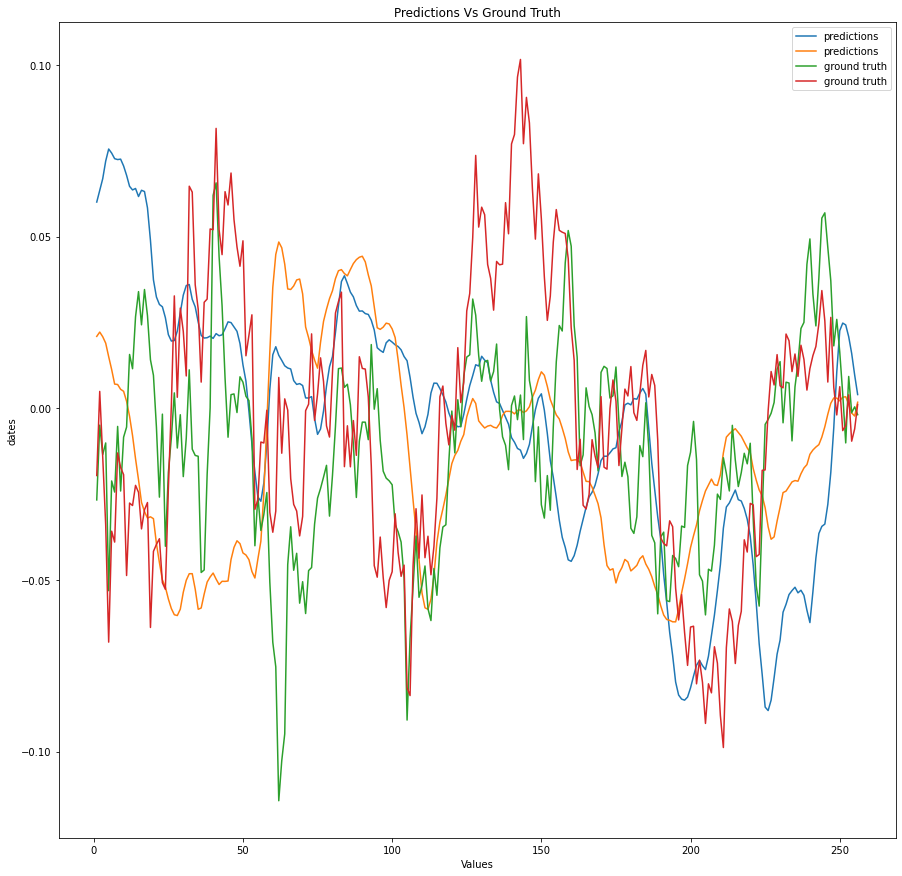

In [ ]:
plt.figure(figsize=(15, 15))

plt.plot(index_1, validation_predictions ,label = "predictions")
plt.plot(index_1, joint_valid_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

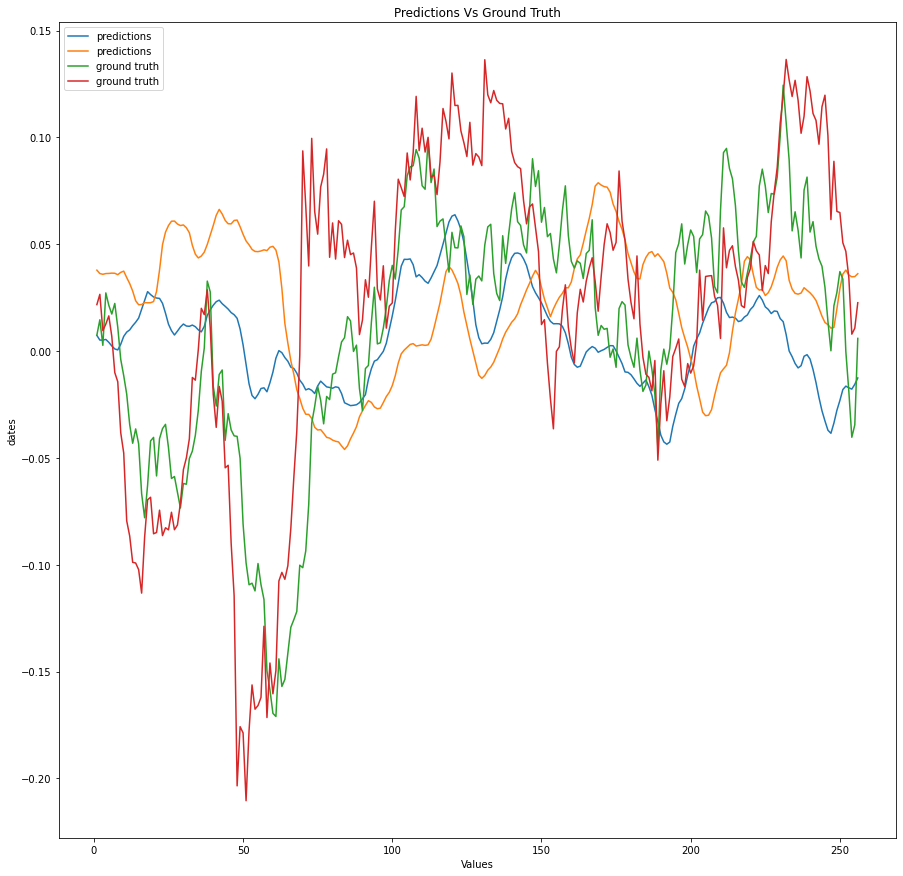

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(index_2,  test_predictions,label = "predictions")
plt.plot(index_2, joint_test_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

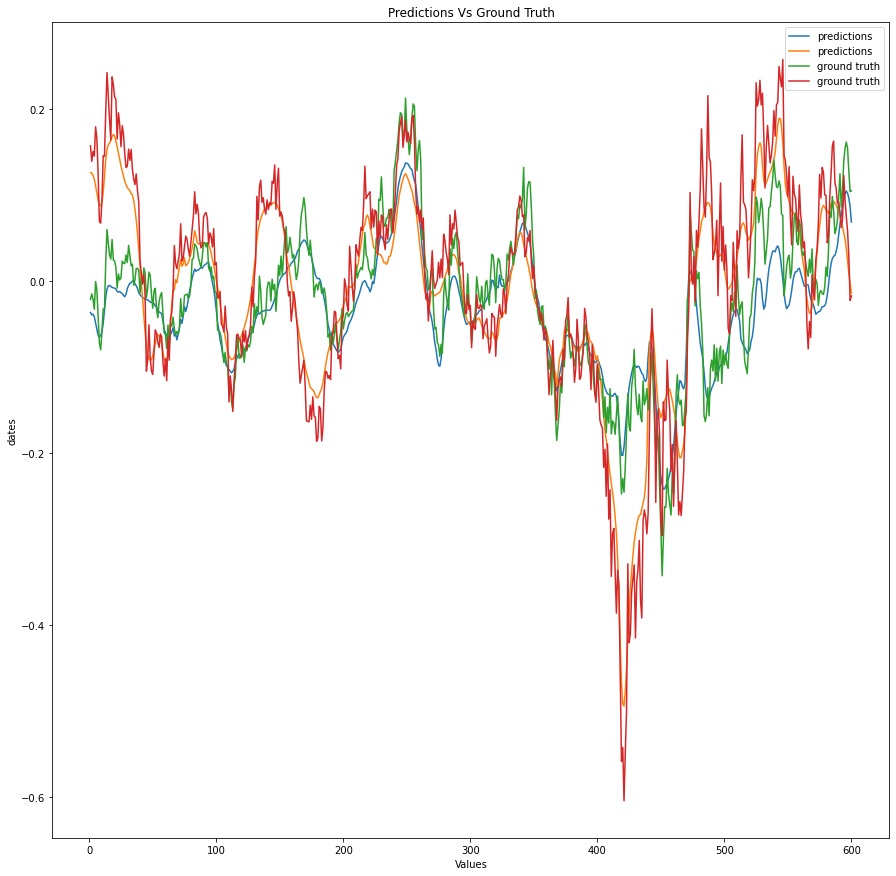

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(index_3[0:600],  train_predictions[0:600],label = "predictions")
plt.plot(index_3[0:600], joint_train_labels[0:600], label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

In [ ]:
print(joint_test_labels.shape)
print(test_predictions.shape)

(256, 2)
(256, 2)


In [ ]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(joint_test_labels,test_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(test_predictions, joint_test_labels)))

Mean Directional Accuracy: 0.5431372549019607
Root Mean Squared Error : 0.07446006


In [ ]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(joint_valid_labels,validation_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(validation_predictions, joint_valid_labels)))

Mean Directional Accuracy: 0.5392156862745098
Root Mean Squared Error : 0.048739012
